In [1]:
%matplotlib inline
import hera_stats as hs
import hera_pspec as hp
import matplotlib.pyplot as plt
import numpy as np
import os
from hera_stats.data import DATA_PATH

In [2]:
# Settings:

# Import settings
container_path = os.path.join(DATA_PATH, "uvp_data.h5")
pc_group = "IDR2_1"
pc_psnames = None

# Analysis settings
pol = "xx"

# Output settings
pc_out = hp.container.PSpecContainer("./jk_data.h5", "rw")

# PSpec settings
sample_baseline = (37, 51)
bl_tol = 0.1

In [3]:
# Open container
pc = hp.container.PSpecContainer(container_path)

# Get pspecs from list or string
if isinstance(pc_psnames, (tuple, list, np.ndarray)):
    uvp_list = [pc.get_pspec(group=pc_group, psname=ps) for ps in pc_psnames]
else:
    uvp_list = pc.get_pspec(group=pc_group, psname=pc_psnames)

In [4]:
# Redundant baseline calculation, given the sample baseline in cell 2.
uvp = hp.uvpspec.combine_uvpspec(uvp_list)

# Get position and baseline information
pos = uvp.get_ENU_bl_vecs()
all_bls = [uvp.bl_to_antnums(b) for b in uvp.bl_array]
dic = dict(zip(all_bls, pos))

# Find baselines that match the sample_baseline vector very closely
bls = []
for b in all_bls:
    if sum((dic[sample_baseline] - dic[b])**2) < bl_tol:
        bls.append(b)
    else:
        print b

uvp 0 and 1 are concatable across blpairts axis
(37, 52)
(38, 53)
(39, 54)
(51, 67)
(52, 68)
(53, 69)


In [5]:
# Omit antenna jackknife
om_a = hs.jackknives.omit_ants(uvp, None, bls=bls)

In [6]:
# bootstrap
_om_a = []
for uvp_list in om_a:
    _ul = []
    for uvp in uvp_list:
        uvp_avg, _, _ = hp.grouping.bootstrap_resampled_error(uvp, blpair_groups=[uvp.get_blpairs()],
                                                              Nsamples=100, seed=0, normal_std=True,
                                                              time_avg=True)
        _ul.append(uvp_avg)
    _om_a.append(_ul)
om_a = _om_a   

In [7]:
# Create jkset
jk = hs.JKSet(om_a, jktype="omit_ants")
jk

<hera_stats.jkset.JKSet instance at 0x10ad895d0>

Jackknife Data
--------------
jktype: omit_ants
data shape: (1, 10)

In [8]:
# Calculate zscores
zs = hs.stats.zscores(jk, axis=1)

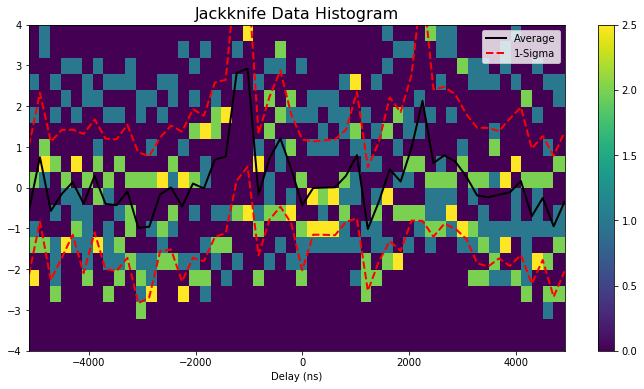

In [9]:
# Plot zscore histogram
hs.plots.hist_2d(zs[0], logscale=False, ylim=(-4,4), ybins=20)

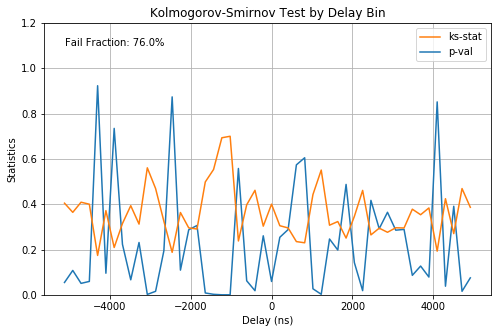

In [10]:
# Test (0, 1) normality
hs.plots.plot_kstest(zs[0])

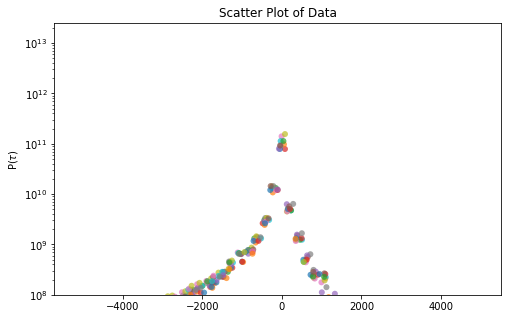

In [11]:
# Look for outliers
hs.plots.scatter(jk[0], ylim=(10**8, 10**12.4))